In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import Rectangle
from numpy.linalg import solve as line_solve

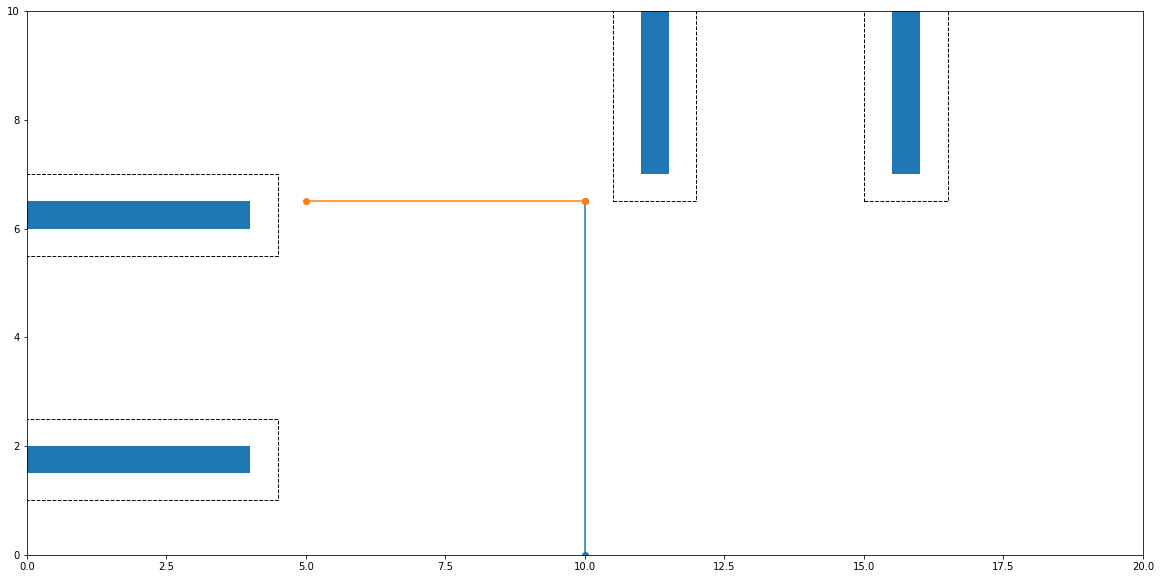

In [3]:
class Environment: 
    
    def __init__(self, arm_1 = 5, arm_2 = 5, theta1=np.pi/2, theta2=0): 
        '''
        Create a simplified environment for the biosafety room two-joint robot
        
        Inputs:
            arm_1 (float): the length of the first arm of the two-joint robot
            arm_2 (float): the length of the second arm of the two-joint robot
            theta1 (float): the initial state of the robot first joint angle with
                            respect to the horizontal axis in radian(s) (0 <= theta1 <= pi)
                            - default pi/2
            theta2 (float): the initial state of the robot second joint angle with
                            respect to the horizontal axis in radian(s) (0 <= theta2 <= 2*pi)
                            - default 0
        Outputs: an instance of the environment object
        
        '''
        
        #Set default parameters for the environment
        self.arm_length_1 = arm_1
        self.arm_length_2 = arm_2
        self.theta1 = theta1
        self.theta2 = theta2
        
        #Calculate the coordinates of the joint and the effector in real space
        self.joint = [10 - self.arm_length_1*np.cos(theta1), self.arm_length_1*np.sin(theta1)]
        self.effector = [self.joint[0] - self.arm_length_2*np.cos(theta2), \
                         self.arm_length_1*np.sin(theta1) + self.arm_length_2*np.sin(theta2)] 
        
        #Creating obstacle, without enlarging
        self.obstacle = []
        self.enlarge = False
    
        #First obstacle
        obstacle = [[0, 2], [4, 2], [4, 1.5], [0, 1.5]]
        self.obstacle.append(obstacle)
        #Second obstacle
        obstacle = [[0, 6.5], [4, 6.5], [4, 6], [0, 6]]
        self.obstacle.append(obstacle)
        #Third obstacle
        obstacle = [[15.5, 10], [16, 10], [16, 7], [15.5, 7]]
        self.obstacle.append(obstacle)
        #Fourth obstacle
        obstacle = [[11, 10], [11.5, 10], [11.5, 7], [11, 7]]
        self.obstacle.append(obstacle)
        
    def set_thetas(self, theta1, theta2):
        '''
        Set the theta values of the robot in its real space
        
        Inputs:
            theta1 (float): the updated state of the robot first joint angle with
                            respect to the horizontal axis in radian(s) (0 <= theta1 <= pi)
            theta2 (float): the updated state of the robot second joint angle with
                            respect to the horizontal axis in radian(s) (0 <= theta2 <= 2*pi)
        
        Outputs: None
        
        '''
        
        #Set thetas 
        self.theta1 = theta1
        self.theta2 = theta2
        
        #Calculate new joints and effector coordinates
        self.joint = [10 - self.arm_length_1*np.cos(theta1), self.arm_length_1*np.sin(theta1)]
        self.effector = [self.joint[0] - self.arm_length_2*np.cos(theta2), \
                         self.arm_length_1*np.sin(theta1) + self.arm_length_2*np.sin(theta2)] 
        
    def enlarge_obstacle(self, rate=0.05): 
        '''
        Create enlarge objects for safety maneuvering
        
        Inputs: 
            rate (float): the rate in which we enlarge the object with respect to the
                          environment size - default 0.05
        
        Outputs: None
        
        '''
        self.enlarge = True
        self.enlarged_obs = []
        
        #Create enlarged obstacles
        for obstacle in self.obstacle: 
            enlarged_obstacle = []
            enlarged_obstacle.append([obstacle[0][0]-10*rate, obstacle[0][1]+10*rate])
            enlarged_obstacle.append([obstacle[1][0]+10*rate, obstacle[1][1]+10*rate])
            enlarged_obstacle.append([obstacle[2][0]+10*rate, obstacle[2][1]-10*rate])
            enlarged_obstacle.append([obstacle[3][0]-10*rate, obstacle[3][1]-10*rate])
            self.enlarged_obs.append(enlarged_obstacle)
        
        #Keep the original obstacles
        self.original_obs = self.obstacle.copy()
        self.obstacle = self.enlarged_obs.copy()
        
    def visualize(self): 
        '''
        Visualize the state of the room and robot arms on the real space
        
        Inputs: None
        
        Outputs: a matplotlib figure object
        
        '''
        plt.figure(figsize=(20,10))
        x1, y1 = [10, self.joint[0]], [0, self.joint[1]]
        x2, y2 = [self.joint[0], self.effector[0]], [self.joint[1], self.effector[1]]
        plt.plot(x1, y1, x2, y2,  marker = 'o')
        ax = plt.gca()
        if self.enlarge == False: 
            for obstacle in self.obstacle:
                ax.add_patch(Rectangle((obstacle[-1][0], obstacle[-1][1]), obstacle[1][0]-obstacle[0][0],\
                                        obstacle[0][1]-obstacle[2][1], alpha=1))
        else: 
            for obstacle in self.obstacle:
                ax.add_patch(Rectangle((obstacle[-1][0], obstacle[-1][1]), obstacle[1][0]-obstacle[0][0],\
                                        obstacle[0][1]-obstacle[2][1], alpha=1, fill=None, linestyle='--'))
            for obstacle in self.original_obs:
                ax.add_patch(Rectangle((obstacle[-1][0], obstacle[-1][1]), obstacle[1][0]-obstacle[0][0],\
                                        obstacle[0][1]-obstacle[2][1], alpha=1))
        plt.xlim(0, 20)
        plt.ylim(0, 10)
        plt.show()

#Testing
env = Environment(6.5, 5)
env.enlarge_obstacle()
env.visualize()

In [4]:
def find_slope(line): 
    '''
    Find the slope and the canonical form of a line given two passing points
    
    Inputs: 
        line (list of lists): a list of two points the line pass through in
                              the form [[x_1, y_1], [x_2, y_2]]
    
    Outputs: the coefficients (a, b, 1) of the line in the canonical form ax+by=1
    
    '''
    
    #Construct a system of linear equations
    M = np.array(line)
    y = np.array([1,1])
    
    #Solve system
    try:
        a, b = line_solve(M, y)[0], line_solve(M, y)[1]
    except np.linalg.LinAlgError: #When the determinant is 0
        a = 0
        b = 1/(line[0][1]+0.00000000001) #For numerical stability
    return (a, b, 1)

def intersection_check(line1, line2):
    '''
    Check whether two line segments intersect or not
    
    Inputs: 
        line1 (list of lists): a list of two points the line pass through in
                              the form [[x_1, y_1], [x_2, y_2]]
        line2 (list of lists): a list of two points the line pass through in
                              the form [[x_1, y_1], [x_2, y_2]]
    
    Outputs: a boolean indicating whether the two segments intersect (True if intersect)
    
    '''
    #Find the canonical form
    a1, b1, c1 = find_slope(line1)
    a2, b2, c2 = find_slope(line2)
    
    #Solve for intersection
    if (a1*b2 - b1*a2) == 0: #When the determinant is 0, no intersection exists
        return False
    else: 
        #When the intersection exists, check whether it's in both segments
        x_intersect = round((c2*b1 - c1*b2)/(b1*a2 - b2*a1), 3)
        y_intersect = round((c1*a2 - c2*a1)/(b1*a2 - b2*a1), 3)
        in_line_1 = ((y_intersect <= max(line1[1][1], line1[0][1])) and (y_intersect >= min(line1[1][1], line1[0][1]))) and \
                    ((x_intersect <= max(line1[1][0], line1[0][0])) and (x_intersect >= min(line1[1][0], line1[0][0])))
        in_line_2 = ((y_intersect <= max(line2[1][1], line2[0][1])) and (y_intersect >= min(line2[1][1], line2[0][1]))) and \
                    ((x_intersect <= max(line2[1][0], line2[0][0])) and (x_intersect >= min(line2[1][0], line2[0][0])))
        if in_line_1 and in_line_2: 
            return True
        else: 
            return False

def collision_check(env, theta1, theta2): 
    '''
    Check whether a specific state in the configuration space results in a collision
    in the real space or not
    
    Inputs: 
        env (Environment object): an environment instance
        theta1 (float): the state of the robot first joint angle with
                        respect to the horizontal axis in radian(s) (0 <= theta1 <= pi)
        theta2 (float): the state of the robot second joint angle with
                        respect to the horizontal axis in radian(s) (0 <= theta2 <= 2*pi)
                        
    Outputs: a string indicating which scenario we are in with this state: "Collide" 
             if we collide with an obstacle, "Out of frame" if the effector go out of 
             the current room and "Safe" otherwise
    
    '''
    
    env.set_thetas(theta1, theta2)
    collide = []
    
    #Detect collision with obstacles
    for obstacle in env.obstacle: 
        cross_1 = intersection_check([obstacle[0], obstacle[1]], [[10, 0], env.joint])
        cross_2 = intersection_check([obstacle[1], obstacle[2]], [[10, 0], env.joint])
        cross_3 = intersection_check([obstacle[2], obstacle[3]], [[10, 0], env.joint])
        cross_4 = intersection_check([obstacle[3], obstacle[-1]], [[10, 0], env.joint])
        if (cross_1 == True) or (cross_2 == True) or \
           (cross_3 == True) or (cross_4 == True):
            collide.append(True)
        else: 
            collide.append(False)
        cross_1 = intersection_check([obstacle[0], obstacle[1]], [env.joint, env.effector])
        cross_2 = intersection_check([obstacle[1], obstacle[2]], [env.joint, env.effector])
        cross_3 = intersection_check([obstacle[2], obstacle[3]], [env.joint, env.effector])
        cross_4 = intersection_check([obstacle[3], obstacle[-1]], [env.joint, env.effector])
        if (cross_1 == True) or (cross_2 == True) or \
           (cross_3 == True) or (cross_4 == True):
            collide.append(True)
        else: 
            collide.append(False)
            
    #Detect effector go out of the room
    joint_in_frame = (env.joint[0] <= 20) and (env.joint[0] >=0) and\
                     (env.joint[1] <= 10) and (env.joint[1] >=-10)
    effector_in_frame = (env.effector[0] <= 20) and (env.effector[0] >=0) and\
                        (env.effector[1] <= 10) and (env.effector[1] >=-10)
    
    if np.array(collide).any(): 
        return 'Collided'
    if (not joint_in_frame) or (not effector_in_frame): 
        return 'Out of frame'
    return 'Safe'

def create_configuration_space(env, n): 
    '''
    From the real space, create a configuration space for the movements of the robot
    
    Inputs: 
        env (Environment object): an environment instance
        n (int): the number of discretization step we want to do
        
    
    Outputs: 
        goal1 (list): a list of tuples indicating the points where we are in the 
                      first biosafety container in the room
        goal2 (list): a list of tuples indicating the points where we are in the 
                      second biosafety container in the room
        collide (list): a list of tuples indicating the points where we collide with
                        obstacles in the real space
        out_of_frame (list): a list of tuples indicating the points where the effector
                             go out of frame
        theta1_step (float): the step size of theta1 
        theta2_step (float): the step size of theta2
    
    '''
    #Discretize the configuration space
    theta1s, theta1_step = np.linspace(0, np.pi, n, retstep=True)
    theta2s, theta2_step = np.linspace(0, 2*np.pi, 2*n, retstep=True)
    collide = []
    out_of_frame = []
    goal1, goal2 = [], []
    
    #Enumarating all possible state in the configuration space and check for collision
    for theta1 in theta1s: 
        for theta2 in theta2s: 
            result = collision_check(env, theta1, theta2)
            if result == 'Collided': 
                collide.append((theta1, theta2))
            elif result == 'Out of frame': 
                out_of_frame.append((theta1, theta2))
            else: 
                if (env.effector[0] <= env.obstacle[0][1][0]) and (env.effector[0] >= 0) and \
                   (env.effector[1] <= env.obstacle[1][2][1]) and (env.effector[1] >= env.obstacle[0][0][1]): 
                    goal1.append((theta1, theta2))
                if (env.effector[0] <= env.obstacle[-2][0][0]) and (env.effector[0] >= env.obstacle[-1][1][0]) and \
                   (env.effector[1] <= 10) and (env.effector[1] >= env.obstacle[-1][-2][1]): 
                    goal2.append((theta1, theta2))
    
    return goal1, goal2, collide, out_of_frame, theta1_step, theta2_step

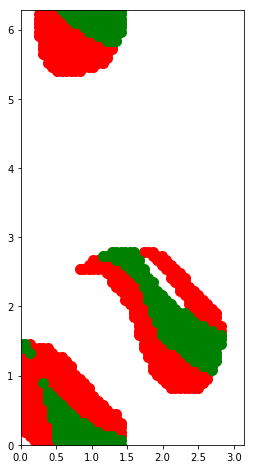

Size of operating space 0.01775


In [24]:
env = Environment(5, 5)
env.enlarge_obstacle()
g1, g2, obs, out, s1, s2 = create_configuration_space(env, 50)

plt.figure(figsize=(4, 8))
for point in obs: 
    x, y = point
    plt.plot(x, y, marker='o', color='r', markersize=10)
for point in out: 
    x, y = point
    plt.plot(x, y, marker='o', color='b', markersize=10)    
for point in g1: 
    x, y = point
    plt.plot(x, y, marker='o', color='g', markersize = 10)   
for point in g2: 
    x, y = point
    plt.plot(x, y, marker='o', color='g', markersize = 10)  
    
plt.ylim(0, 2*np.pi)
plt.xlim(0, np.pi)
plt.show()

print('Size of operating space', (len(g1)+len(g2))/(100*200))

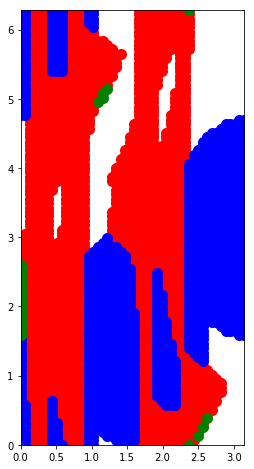

Size of operating space 0.0013


In [25]:
env = Environment(10, 5)
env.enlarge_obstacle()
g1, g2, obs, out, s1, s2 = create_configuration_space(env, 50)

plt.figure(figsize=(4,8))
for point in obs: 
    x, y = point
    plt.plot(x, y, marker='o', color='r', markersize=10)
for point in out: 
    x, y = point
    plt.plot(x, y, marker='o', color='b', markersize=10)    
for point in g1: 
    x, y = point
    plt.plot(x, y, marker='o', color='g', markersize = 10)   
for point in g2: 
    x, y = point
    plt.plot(x, y, marker='o', color='g', markersize = 10)  
    
plt.ylim(0, 2*np.pi)
plt.xlim(0, np.pi)
plt.show()

print('Size of operating space', (len(g1)+len(g2))/(100*200))

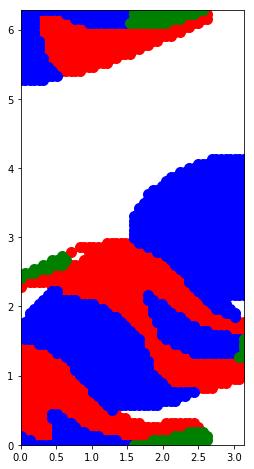

Size of operating space 0.00575


In [26]:
env = Environment(5, 10)
env.enlarge_obstacle()
g1, g2, obs, out, s1, s2 = create_configuration_space(env, 50)

plt.figure(figsize=(4,8))
for point in obs: 
    x, y = point
    plt.plot(x, y, marker='o', color='r', markersize=10)
for point in out: 
    x, y = point
    plt.plot(x, y, marker='o', color='b', markersize=10)    
for point in g1: 
    x, y = point
    plt.plot(x, y, marker='o', color='g', markersize = 10)   
for point in g2: 
    x, y = point
    plt.plot(x, y, marker='o', color='g', markersize = 10)  
    
plt.ylim(0, 2*np.pi)
plt.xlim(0, np.pi)
plt.show()

print('Size of operating space', (len(g1)+len(g2))/(100*200))

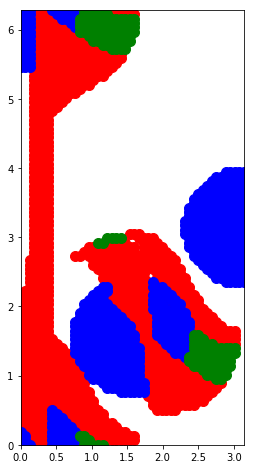

Size of operating space 0.00895


In [27]:
env = Environment(6, 6)
env.enlarge_obstacle()
g1, g2, obs, out, s1, s2 = create_configuration_space(env, 50)

plt.figure(figsize=(4,8))
for point in obs: 
    x, y = point
    plt.plot(x, y, marker='o', color='r', markersize=10)
for point in out: 
    x, y = point
    plt.plot(x, y, marker='o', color='b', markersize=10)    
for point in g1: 
    x, y = point
    plt.plot(x, y, marker='o', color='g', markersize = 10)   
for point in g2: 
    x, y = point
    plt.plot(x, y, marker='o', color='g', markersize = 10)  
    
plt.ylim(0, 2*np.pi)
plt.xlim(0, np.pi)
plt.show()

print('Size of operating space', (len(g1)+len(g2))/(100*200))

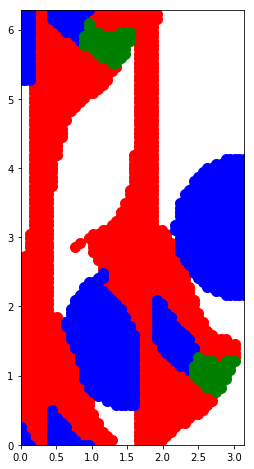

Size of operating space 0.00565


In [28]:
env = Environment(7, 6)
env.enlarge_obstacle()
g1, g2, obs, out, s1, s2 = create_configuration_space(env, 50)

plt.figure(figsize=(4,8))
for point in obs: 
    x, y = point
    plt.plot(x, y, marker='o', color='r', markersize=10)
for point in out: 
    x, y = point
    plt.plot(x, y, marker='o', color='b', markersize=10)    
for point in g1: 
    x, y = point
    plt.plot(x, y, marker='o', color='g', markersize = 10)   
for point in g2: 
    x, y = point
    plt.plot(x, y, marker='o', color='g', markersize = 10)  
    
plt.ylim(0, 2*np.pi)
plt.xlim(0, np.pi)
plt.show()

print('Size of operating space', (len(g1)+len(g2))/(100*200))

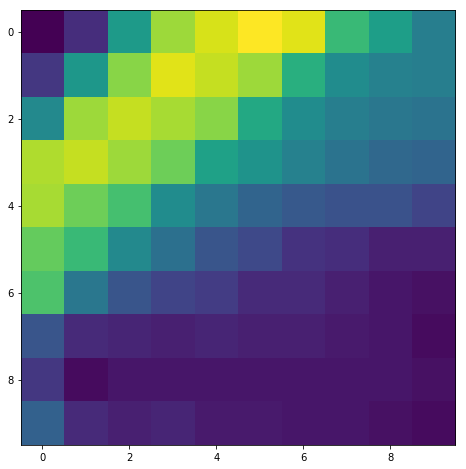

In [58]:
#Searching for the optimal arm lengths
arm_1 = np.linspace(3, 10, 10)
arm_2 = np.linspace(3, 10, 10)

ps = []
for arm1 in arm_1:
    for arm2 in arm_2:
        n = 20
        env = Environment(arm1, arm2)
        env.enlarge_obstacle()
        g1, g2, obs, out, s1, s2 = create_configuration_space(env, n)
        ps.append((len(g1)+len(g2))/(2*n**2))
        
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(np.array(ps).reshape(10,10))
plt.show()

In [6]:
#Constructing a Voronoi diagram from the free space samples
from scipy.spatial import Voronoi, voronoi_plot_2d

env = Environment(5, 5)
env.enlarge_obstacle()
g1, g2, obs, out, s1, s2 = create_configuration_space(env, 50)

In [34]:
def free_space_sample(n, collide, out_frame, rate=0.8): 
    theta1s = np.linspace(0, np.pi, n)
    theta2s = np.linspace(0, 2*np.pi, 2*n)
    not_free = collide + out_frame
    samples = []
    for theta1 in theta1s: 
        for theta2 in theta2s:
            point = (theta1, theta2)
            try: 
                not_free.index(point)
                continue
            except ValueError: 
                if np.random.random() < rate: 
                    samples.append(point)
    return samples

samples = free_space_sample(100, obs, out, rate=0.01)

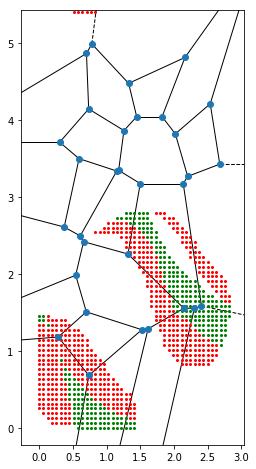

In [24]:
fig, ax = plt.subplots(figsize=(4, 8))
for point in obs: 
    x, y = point
    plt.plot(x, y, marker='o', color='r', markersize=2)
for point in out: 
    x, y = point
    plt.plot(x, y, marker='o', color='b', markersize=2)    
for point in g1: 
    x, y = point
    plt.plot(x, y, marker='o', color='g', markersize=2)   
for point in g2: 
    x, y = point
    plt.plot(x, y, marker='o', color='g', markersize=2)
    
plt.ylim(0, 2*np.pi)
plt.xlim(0, np.pi)
vor = Voronoi(samples)
voronoi_plot_2d(vor, show_points=False, ax = ax )

plt.show()

(0, 3.141592653589793)

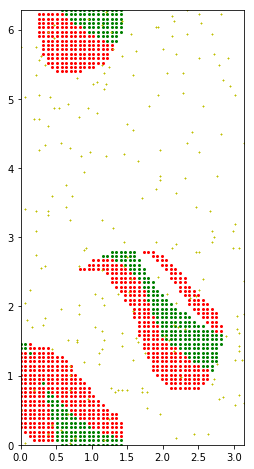

In [35]:
fig, ax = plt.subplots(figsize=(4, 8))
for point in obs: 
    x, y = point
    plt.plot(x, y, marker='o', color='r', markersize=2)
for point in out: 
    x, y = point
    plt.plot(x, y, marker='o', color='b', markersize=2)    
for point in g1: 
    x, y = point
    plt.plot(x, y, marker='o', color='g', markersize=2)   
for point in g2: 
    x, y = point
    plt.plot(x, y, marker='o', color='g', markersize=2)   
for point in samples: 
    x, y = point
    plt.plot(x, y, marker='+', color='y', markersize=2)
    
plt.ylim(0, 2*np.pi)
plt.xlim(0, np.pi)

In [ ]:
#Sample output from for MTCS algorithm

theta1, theta2 = np.pi/2, 0
start_state = (theta1, theta2)

env = Environment(6, 6, theta1=theta1, theta2=theta2)
env.enlarge_obstacle()
g1, g2, obs, out, s1, s2 = create_configuration_space(env, 50)

end_state_1 = g1
end_state_2 = g2
boundary = obs + out
step_size = (s1, s2)

#Outputs for the MTCS
'''
start_state (tuple)

end_state_1 (list of tuples)

end_state_2 (list of tuples)

boundary (list of tuples)

step_size (tuple): (theta1_size, theta2_size) 
'''

